### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# Optimal Skill-Based Worker Assignment

#### Noah Rhodes (nrhodes@wisc.edu), Alliot Nagle (acnagle@wisc.edu), and Liam Marshall (limarshall@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Model 1: Simple Assignment](#2.A-Model-1:-Simple-Assignment)
  1. [Model 2: Variety Assingment](#2.B-Model-2:-Variety-Assingment)
  1. [Model 3: Binary Task Bundlles](#2.C-Model-3:-Binary-Task-Bundles)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Model Solving Speed](#4.A-Model-Solving-Speed)
  1. [Data Interpretation](#4.B-Data-Interpretation)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

An important aspect of project management is assigning employees to tasks, and doing so in an efficient manner.
Several aspects can be considered such as decreasing worker boredom _[1]_, maximizing productivity, or increasing robustness to workers not showing up.

Our project is focusing on minimizing the time to complete a project, given a set of workers and tasks.
Our unique twist is to account for how repeating a task can lead to decreasing time required to complete it, which we call the worker’s _learning model_.

The goal of the project is to find an optimal schedule for assigning workers with specific set of skills to a set of tasks.
Each task has a defined amount of work that needs to be done in order to complete a task, and the amount of time a worker spends on completing a task depends on his or her skill set.
In addition, when a worker completes a task, they become more skilled at performing that task, completing it more quickly in the future.
An optimal schedule could minimize the length of a project timeline by assigning workers to tasks that match the skills they have, or it might assign a low skill worker to a job several times to in order for them to learn the skill and be highly productive in the long run.  

The inspiration for this project comes from work with Engineers Without Borders.
As designs for a bridge, a microgrid, or a water system are finalized, a construction schedule must be planned.
Every household in the community contributes a person to the construction, which means access to a large amount of labor; however, these workers are not typically highly skilled in the type of required work.
However, at low skill levels, repeated work can lead to a rapidly increasing productivity **[cite?]**.
A tool to better estimate how worker productivity may change over the course of a project would dramatically help in the creation of feasible project timelines. 

In large projects, the number of tasks often significantly outnumbers the workers and we must decide how to assign our workers.
Do we have workers that specialize in a task and complete it quickly, or instead have workers who can generalize and complete a variety of tasks more slowly.  How do we assign our workers to a project timeline to optimize the completion time?

We develop a model to find an optimal schedule for worker assignment based on the amount of work each task requires and the skill level of each worker.
This model can be useful for a wide array of applications.
For example, developing a construction timeline and determining what combination of worker assignments will allow a project to be completed quickly.
An additional use may be to decide if it will be more productive to have a worker learn on the job or instead give a worker training where they stop producing work but may return with a higher skill level. 

We data for our model, using very broad assumptions/estimates.
Our goal is to prove that that our model can be viable for a variety of assignment problems, rather focus on a specific worker dataset.
We will create worker skill levels and learning speeds from random distrobutions restricted to a sensible range of values.

Depending on the variety of types of tasks in a project, the quantity of those tasks, the number of workers, and any initial skills the workers have, we can expect a different optimal assignment of tasks to workers.
This is leads to a question of whether workers should generalize or specialize in a skill, or how short-term optimal worker assignment compares to long-term optimal assignment.
Our project hopes to provide an answer to these questions and their dependency on initial conditions. 

----

[1]: Bhadury, J., and Z. Radovilsky. "Job rotation using the multi-period assignment model." _International Journal of Production Research_ 44.20 (2006): 4431-4444.

## 2. Mathematical model ##


Our problem is economic question of worker productivity and how it can be maximized by modeling how worker productivity changes over time.  We plan to model effects that increase productivity such as repeating a similar task or providing training, as well as effects that decrease productivity such as forgetting a skill over time.  

Our project is a blend of an assignment problem and a planning problem, where we assign workers to tasks in the planning problem, and the speed of completing a tasks in the planning problems depends on the worker productivity, which changed based on previous assignments.  The complexity of our project is the result of of this feedback between these two models, resulting in a considerable amount of logic constraints, a large solution space, and significant scaling challenges.  We hope to find methods of modeling this problem as a flow problem, as both subsets of this problem can be modeled in this way, in order to remove the integer constraints on our assignments and model this problem as Linear Program, rather than an Integer program.  We begin with small models incorporating small sections of our target model.  Our goal is to create a model that does the following:


$\begin{equation*}
\begin{aligned}
& \underset{\text{Worker Assingment}}{\text{Minimize}}
& & \textrm{Time to complete all tasks} \\
& \text{subject to:}
& & \text{Each task must be completed}  \\ 
& & & \text{Each worker is assigned one task at a time} \\
& & & \text{Worker productivity changes based on past assingments}\\
\end{aligned}
\end{equation*}
$

### 2.A Model 1: Simple Assignment ###

Our first model is an intial proof of concept that will allow us to see initial shortcomings of a more complex model.  In this model, we have only one type of task, all workers complete tasks in the same amount of time, and no worker-learning is modeled.  We attempt to create a very simple model under these conditions that will be easy to scale and add other model characteristics.

Based on our project goals, we realized we would need to evaluate discrete time points to decide when a worker is working on a given task, when they start the next task, and how working on a task now changes the speed of working on future tasks in later iterations of our model.  


$\begin{equation*}
\begin{aligned}
& \underset{x_{ijk} \ \lambda}{\text{Minimize}}
& & \lambda \\
& \text{subject to:}
& & \sum\limits_{i=1}^T x_{ijk} \le 1 
& \forall j, k \\ 
& & & \sum\limits_{j=1}^W \sum\limits_{k=1}^M x_{ijk} == 1
& \forall i \\
& & & \sum\limits_{j=1}^W \sum\limits_{k=1}^M x_{ijk}*k \leq \lambda
& \forall i \\
& & & x_{ijk} \in \{0,1\} \\
\\
& \text{Where}
&  W \ & \text{Number of Workers}\\
&  & T \ & \text{Number of Tasks}\\
&  & M \ & \text{Upper bound on completion time}
\end{aligned}
\end{equation*}
$

The objective is to minimize the time to complete all tasks, which is accomplished using an epigraph technique to enforce an infinty norm.  We require that each task be assigned once to a single worker across all timesteps. We then constrain each worker to be assinged to a maximum of one task at each timestep. The final constraint enforces the epigraph that minimizes the timestep during which the final task is assigned.  





In [2]:
#########################
# Simple Assingment Model
#########################
N = 50 # tasks
M = 9 # workers
T = N #upper bound on project completion

using JuMP, Gurobi

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    solve(m)
                
println("Minimum time to complete tasks: ", getvalue(last))

INFO: Recompiling stale cache file C:\Users\Noah Rhodes\AppData\Local\JuliaPro\pkgs-0.6.2.1\lib\v0.6\Gurobi.ji for module Gurobi.


Academic license - for non-commercial use only
Minimum time to complete tasks: 7.0


This creates an assingment schedule for each worker

**[Model 1 Schedule]**




This model performs as expected.  If each worker completes every job at the same pace, the most efficent method of dividing the work is to have each worker be assigned the same number of tasks. The next step is to model the variety of skills each worker may have.    

### 2.B Model 2: Variety Assingment ###

Using the first model as a basis, we wanted to include non-unique worker skills and a variety of task types.  For example, in the Engineers Without Borders project we may have some workers who are more skilled in laying concrete for water tanks and others who are more skilled in digging and laying pipes for the water lines.  How do we assign these workers optimally when the number of workers skilled in a task does not match the work that must be accomplished in that task? 

The next step is to incorporate a variety of types of tasks and workers who have a different completion time for each task.  This requires some additional logic constraints that massively increased the complexity of solving this model in comparison to *Model 1 - Simple Assingment*.  Instead of requiring the sum along the task dimension of $x_{ijk}$ to be equal to one to enforce the completetion of each task,  we now have tasks that require an uknown amount of time to complete depnding on the worker who is assigned.  Additionally the constraint for enforcing each worker to be assigned no more than one task simultaneously in complicated by the variety of tasks that may assigned from from any of the assignemnt groups.


$\begin{equation*}
\begin{aligned}
& \underset{x_{ijkt} \ z_{ijkt} \ \lambda}{\text{Minimize}}
& & \lambda \\
& \text{subject to:}
& & \sum\limits_{k=1}^{w}  \sum\limits_{t=1}^T z_{ijkt} \le 1 & \forall i,j\\ 
& & & \sum\limits_{i=1}^n \sum\limits_{j=1}^v x_{ijkt} = 1  & \forall k,t\\
& & & \sum\limits_{i=1}^n \sum\limits_{k=1}^w \sum\limits_{t=1}^T x_{ijkt} = N_j & \forall j\\
& & & z_{ijkl} >= x_{ijkt} & \text{for } l=t,...,W_{kj}\\
& & & \left[ \sum\limits_{t=1}^T x_{ijkt}*(t+W_{kj}) \right] \le \lambda & \forall i,j,k
\end{aligned}
\end{equation*}
$

$\begin{equation*}
\begin{aligned}
& \text{Where}
&  z_{ijkt} & \in [0,1] \ \text{Is true if worker $i$ is working on the $k$th task of type $j$ at time $t$}\\ 
& & x_{ijkt} & \in [0,1] \ \text{Is true if  worker $i$ is starts the $k$th task of type $j$ at time $t$}\\ 
&  & W  & \text{Array of $n$ workers by $v$ task types that contains the speed which each worker can complete each task type}\\
&  & N  & \text{Array of $v$ task types that contains the quota of each task type} \\
& & T  & \text{ Upper bound on the number of required discrete timesteps} \\
\end{aligned}
\end{equation*}
$

In [3]:
using JuMP, Gurobi

N = rand(15:25,1, 2)  # 5 tasks, with quotas ranging from 15 to 25
W = rand(1:10, 6, 2)  # 6 workers with task completion speeds ranging from 1 to 10

# Task/Worker Parameters
    ###############################

    ## We require 5 of task_1, 1 of task_2, etc.
    n = maximum(N) #max number of tasks for a category
    v = size(N,2) # number of types of tasks

    ## Each row of W is a worker, and the column is the time required for the worker to complete that task
    w = size(W,1) #number of workers

    T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

    ###############################

    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
    @variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

    @variable(m, λ)

    #If a worker starts a task at time t, z if true until the tasks completes
    for i=1:n
        for j=1:v
            for k=1:w
                for t=1:T
                    #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                    if t < T-convert(Int64,W[k,j])
                        @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    else
                        @constraint(m, [l=1:T-t], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    end
                end
            end
        end
    end

    #only one task in z can be worked simultaneously
    @constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1) ###

    #expression is used as an epigraph to find the end time of the last task
    @expression(m, end_t[i=1:n, j=1:v, k=1:w], sum((x[i,j,k,t])*(t+W[k,j]) for t=1:T)) ###
    @expression(m, start_t[i=1:n, j=1:v, k=1:w], sum((x[i,j,k,t])*(t) for t=1:T))
    
    # each task is only worked on once and all tasks are completed
    @constraint(m, [i=1:n, j=1:v], sum(x[i, j, :, :]) <= 1)  ###
    @constraint(m, [j=1:v], sum(x[:,j,:,:]) == N[j])  ###
    
    # min { max_j end_t[j] }
    @constraint(m, [i=1:n, j=1:v, k=1:w], λ >= end_t[i,j,k])
    
    @objective(m, Min, λ)    
    solve(m)
    timer = getsolvetime(m)
println("The minimum completion time is: ", getobjectivevalue(m))

Academic license - for non-commercial use only
The minimum completion time is: 25.0


The solution to this model provides us with a the a worker schedule that is the optimal distribution of tasks according the speed that each worker complete eany task.

In [5]:
## Worker Assingments for Model 2 ##

As we developed this model, we realized it was similar to a quadratic assingment problem. A quadractic assingment problem follows this format:

> Assign facilities to fixed locations. The facilities
have known communication requirements and incurred
costs depend on the distances between the facilities.

**[Cite Lecture 22]**

In our example, each worker is a "facility" and each task type is a "location".  We have "communication constraints" and costs each time a worker is assigned as task in each "location".  As a result, we have a quadractic assingment that that contains on the order of $w_{workers}*v_{task types}*n_{tasks}*t_{time steps}$. To apply a model to a useful scenario size, we would require  $\approx 10^5$ boolean variables, a problem size that requires far more computation time than is reasonable for this project.  Further analysis of the relative speeds of each model is shown is section [Section 4.1](#4.1-Model-Solving-Speed)

Our original goal was to create a an amalgamation of an assingment problem with a planning problem, both Linear Programs, that could also be modeled as an LP, or at least solve on a similar timescale. 
In order to do this, we need to relax some requirements to our problem in order attempt to address our primary focus: how do worker skills change as over the course of a project as they are assigned a variety of tasks.  

### 2.C Model 3: Binary Task Bundles ###

In our third model, we relax the requirement of finding an ordering of the tasks each worker completes.  We assume that the learning process for each worker will depend on the number of times that task is completed and not on the temporal density of assingments. This also means that we will not have the option to enforce any ordering in which the tasks take place and so will not be able to set prerequisite task completions.

However, we are now able to model our problem as a min-cost flow problem. Unfortuantely the objective is nonlinear once we model worker learning, meaning that we need boolean constraints on our worker assingments.  This means that we have a mixed integer program rather a linear program, but it solves considerably faster than Model 2, as shown in [Section 4.1](#4.1-Model-Solving-Speed).

$\begin{equation*}
\begin{aligned}
& \underset{x \ \lambda} {\text{Minimize}}
& & \lambda \\
& \text{subject to:}
\end{aligned}
\end{equation*}
$

$\begin{equation*}
\begin{aligned}
& \text{Where}
& & T  & \text{ Upper bound on the number of required discrete timesteps} \\
\end{aligned}
\end{equation*}
$


In [6]:
# Draw a flow of what this problem looks like?

To model the worker learning, we assume each additional task is can be completed according to a linearly decreasing functions, with a cap on the maximum speed that can be achieved.  

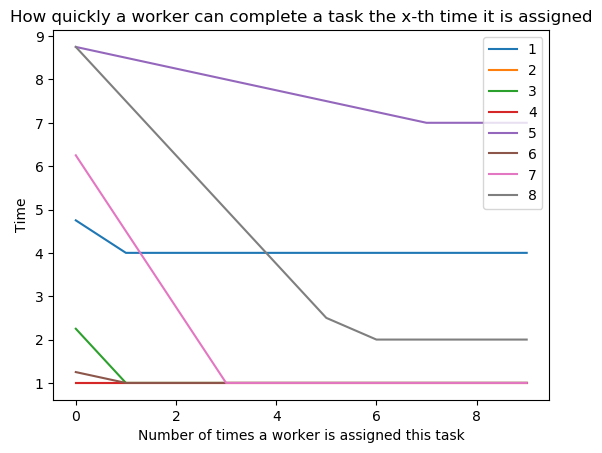

In [38]:
using PyPlot
n_tasks = 8
horizon = 10
initial_task_lengths = rand(1:10, n_tasks)
learning_speed = rand(0.25:0.5:1.75, n_tasks)
min_task_lengths = max.(1, initial_task_lengths - rand(1:10, n_tasks))

task_completion_speed = [(max.(min_task_lengths[j], initial_task_lengths[j]-T*learning_speed[j])) for j in 1:n_tasks, T in 1:horizon]

plot(task_completion_speed')
legend(1:n_tasks); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete a task the x-th time it is assigned");

From this, the total time to complete $n$ tasks is the sumation from $1$ to $n$ for each task type.  We calculate this value to be used in the cost function of our model

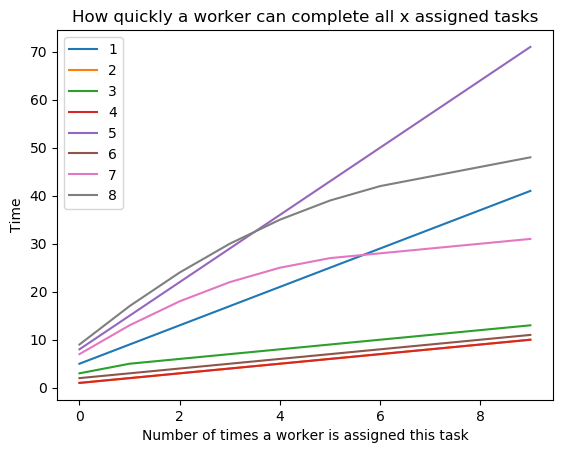

In [40]:
task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:n_tasks, T in 1:horizon]

plot(task_bundle_times')
legend(1:n_tasks); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete all x assigned tasks");

This cost function is used to estimate how quickly workers can learn a task.  The exact shape of the function is not empircal, but a more accurate function could easily be accomodated with our model as it only requires the amount of time for worker $i$ to finish $j$ tasks of type $k$, and any dataset could be applied.  We could even model a slowdown in worker productivity if they are assigned a task too many times and they become bored and unproductive.  Our model is shown below.

In [43]:
    # Task/Worker Parameters
    ###############################
    quotas = rand(8:12,1,5) # 5 types of tasks with random quotas between 8 and 12
    n_workers = 5           # 5 workers
    m_tasks = length(quotas)
    horizon = maximum(quotas)

    initial_task_lengths = rand(1:10, m_tasks)
    min_task_lengths = max.(1, initial_task_lengths - rand(1:10, m_tasks))
    task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:m_tasks, T in 1:horizon]

    ###############################

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

    for i in 1:n_workers, j in 1:m_tasks
        addSOS1(m, work[i,j,:])
    end

    # ∞-norm epigraph bounds for slowest_worker
    @constraints(m, begin
        worker_speed .<= slowest_worker
        -slowest_worker .<= worker_speed
    end)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)
    
    solve(m)
    timer = getsolvetime(m)
println("The minimum completion time is: ", getobjectivevalue(m))

Academic license - for non-commercial use only
The minimum completion time is: 27.0


Once we know the optimal division of labor between workers, we can construct a schedule for each worker.  While there are many different possible ways to arrange the tasks, we choose to schedule each task type sequentially.

In [1]:
## Code to show schedule for Model 3

## 3. Solution ##

*Here, you should code up your model in Julia + JuMP and solve it. Your code should be clean, easy to read, well annotated and commented, and it should compile! You are not allowed to use other programming languages or DCP packages such as `convex.jl`. I will be running your code. I suggest having multiple code blocks separated by text blocks that explain the various parts of your solution. You may also solve several versions of your problem with different models/assumptions.*

*It's fine to call external packages such as `Gurobi`, but try to minimize the use of exotic libraries.*


**Intro to what we discuss in this section**



## 4. Results and discussion ##

*Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.*

*Use plots (see `PyPlot` examples from class), or you can display results in a table like this:*


### 4.A Model Solving Speed ###
**Discuss the solver speeds here**
 Place data from the timeing models in here to plot.  We can put the code to run the timing into the appendix

### 4.B Data Interpretation###
**Interpret our 3rd model with different starting conditions of workers/tasks here**

### 4.C Anything to discuss? ###

## 5. Conclusion ##

*Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.*

Follow up: 

Accurate learning models from literature
Modeling decreases in task completion speed in addition to speed up

Does the time upper bound cause significant slowdown in model 2?  If so, better up bounding?

Model a series of consectivite task bundles, such as how many of all required substasks are required to build a boat can be accomplished each month.  How does being able to anticpate the skills needed months in advance help plan for trainng workers in advance of struggling to meet time limits? (adaption of overtime work from lecture early in the semester...more productive workers can lead to less overtime spending)

Using this model in a subset of of project timeline:  We are constructing a building, and each step has several required subtasks.  Our model can solve for the speed of completing all subtasks at each step, how does this impact an entire construction timeline for a building?



